In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import copy

font_path = "C:/Windows/Fonts/MALGUN.TTF"
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
plt.rc('xtick', labelsize=10)
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
# 데이터 셋 불러오기

train = pd.read_csv("../../../data/dacon_parking_demand_dataset/train.csv")
test = pd.read_csv("../../../data/dacon_parking_demand_dataset/test.csv")
sub = pd.read_csv("../../../data/dacon_parking_demand_dataset/sample_submission.csv")
age = pd.read_csv("../../../data/dacon_parking_demand_dataset/age_gender_info.csv")

In [3]:
train.shape, test.shape

((2952, 15), (1022, 14))

In [4]:
# 오류1번 트레인 셋 처리
# 총세대수와 전용면적별 세대수 합이 다른 단지코드의 값을 -> 전용면적별세대수의 합으로 수정하기

def house_number_correction(df):
    error_1_group = df.groupby("단지코드")[["총세대수"]]
    total_number_house_hold = error_1_group.mean()

    error_2_group = df.groupby("단지코드")["전용면적별세대수"]
    sum_house_hold = error_2_group.sum()

    check_df = pd.concat([total_number_house_hold, sum_house_hold], axis=1)
    different_df = check_df[check_df["총세대수"] != check_df["전용면적별세대수"]]

    total_house_index = different_df.index
    total_house_number = []
    for v in different_df.values:
        total_house_number.append(v[1])
    
    for code, value in zip(total_house_index, total_house_number):
         df.loc[df["단지코드"] == code, "총세대수"] = value
    
    return df

train = house_number_correction(train)
test = house_number_correction(test)

In [5]:
error_1_group = train.groupby("단지코드")[["총세대수"]]
total_number_house_hold = error_1_group.mean()

error_2_group = train.groupby("단지코드")["전용면적별세대수"]
sum_house_hold = error_2_group.sum()

check_df = pd.concat([total_number_house_hold, sum_house_hold], axis=1)
check_df = check_df[check_df["총세대수"] != check_df["전용면적별세대수"]]

print(check_df.shape)
check_df

(0, 2)


,총세대수,전용면적별세대수
단지코드,,


In [6]:
error_1_group = test.groupby("단지코드")[["총세대수"]]
total_number_house_hold = error_1_group.mean()

error_2_group = test.groupby("단지코드")["전용면적별세대수"]
sum_house_hold = error_2_group.sum()

check_df = pd.concat([total_number_house_hold, sum_house_hold], axis=1)
check_df = check_df[check_df["총세대수"] != check_df["전용면적별세대수"]]

check_df.shape

(0, 2)

In [7]:
# 오류2번 3번 처리하기

train[(train["단지코드"] == "C2675") | (train["단지코드"] == "C2335") | (train["단지코드"] == "C1327")]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수


In [8]:
test[(test["단지코드"] == "C2675") | (test["단지코드"] == "C2335") | (test["단지코드"] == "C1327")].head(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
579,C2675,512,아파트,경기도,국민임대,36.65,130,9.0,A,18476000,154790,0.0,3.0,1016.0
580,C2675,512,아파트,경기도,국민임대,46.90,44,9.0,A,34082000,232200,0.0,3.0,1016.0
581,C2675,512,아파트,경기도,국민임대,46.90,80,9.0,A,34082000,232200,0.0,3.0,1016.0


In [9]:
# 테스트 데이터 셋에서 세개의 코드 데이터를 없애기 (2, 3번 3개 코드 제거)

error_index = test[(test["단지코드"] == "C2675") | (test["단지코드"] == "C2335") | (test["단지코드"] == "C1327")].index
test = test.drop(index=error_index, axis=0)

In [10]:
# 에러2번의 5개 단지코드 트레인 셋 제거

train_set_error_index = train[(train["단지코드"] =="C2085") | (train["단지코드"] =="C1397") | (train["단지코드"] =="C2431") | (train["단지코드"] =="C1649") | (train["단지코드"] =="C1036")].index
train = train.drop(index=train_set_error_index, axis=0)

In [11]:
# 에러3번의 트레인 셋 7개 단지 코드 제거

train_set_error_index = train[(train["단지코드"] =="C1095") | (train["단지코드"] =="C2051") | (train["단지코드"] =="C1218") | (train["단지코드"] =="C1894") | (train["단지코드"] =="C2483") | (train["단지코드"] =="C1502") | (train["단지코드"] =="C1988")].index
train = train.drop(index=train_set_error_index, axis=0)

In [12]:
# 자격 유형 피처 전처리

test.loc[196, "자격유형"] = "A"
test.loc[258, "자격유형"] = "C"
test.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           180
임대료                             180
도보 10분거리 내 지하철역 수(환승노선 수 반영)     38
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
dtype: int64

In [13]:
train.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           569
임대료                             569
도보 10분거리 내 지하철역 수(환승노선 수 반영)    207
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
등록차량수                             0
dtype: int64

In [14]:
# 임대보증금 피처 전처리
# 임대보증금이 0인 행의 데이터를 -> 트레인 셋의 중앙값으로 치환

train_df = train.copy(deep=True)
test_df = test.copy(deep=True)

train_df["임대보증금"] = train_df["임대보증금"].fillna(0)
train_df.loc[train_df["임대보증금"] == "-", "임대보증금"] = 0
train_df["임대보증금"] = train_df["임대보증금"].astype(int)
train_df.loc[train_df["임대보증금"] == 0, "임대보증금"] = train_df["임대보증금"].median()

test_df["임대보증금"] = test_df["임대보증금"].fillna(0)
test_df.loc[test_df["임대보증금"] == "-", "임대보증금"] = 0
test_df["임대보증금"] = test_df["임대보증금"].astype(int)
test_df.loc[test_df["임대보증금"] == 0, "임대보증금"] = train_df["임대보증금"].median()

In [15]:
# 레이블 인코딩인데, 원핫 인코딩으로 바꿔보기

qualification_type_feature = pd.get_dummies(train_df["자격유형"])
train_df = pd.concat([train_df, qualification_type_feature], axis=1)

qualification_type_feature = pd.get_dummies(test_df["자격유형"])
test_df = pd.concat([test_df, qualification_type_feature], axis=1)

test_df["B"] = 0
test_df["F"] = 0
test_df["O"] = 0

In [16]:
train_df.shape, test_df.shape

((2869, 30), (1008, 29))

In [17]:
# 실거주 세대수 피처 생성

train_df["실거주세대수"] = train_df["총세대수"] - train_df["공가수"].astype(int)
test_df["실거주세대수"] = test_df["총세대수"] - test_df["공가수"].astype(int)

In [18]:
# 세대수 별 주차면수 피처 생성

train_df["세대수비율주차면수"] = (train_df["전용면적별세대수"] / train_df["실거주세대수"]) * train_df["단지내주차면수"]
test_df["세대수비율주차면수"] = (test_df["전용면적별세대수"] / test_df["실거주세대수"]) * test_df["단지내주차면수"]

In [19]:
# 버스정류장 피처 전처리
# 최빈값인 2로 채우기

train_df["도보 10분거리 내 버스정류장 수"] = train_df["도보 10분거리 내 버스정류장 수"].fillna(2)
test_df["도보 10분거리 내 버스정류장 수"] = test_df["도보 10분거리 내 버스정류장 수"].fillna(2)

In [20]:
# 전철역 피처 전처리
# Null 값 0으로 채우기

train_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"] = train_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"].fillna(0)
test_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"] = test_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"].fillna(0)

<AxesSubplot:>

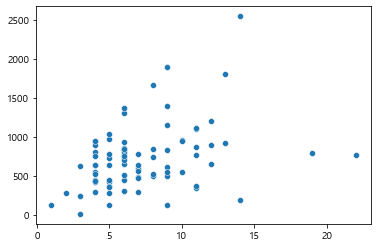

In [21]:
area_group = train_df.groupby("지역")["등록차량수"]

values = area_group.get_group("경기도").value_counts().index
counts = area_group.get_group("경기도").value_counts().values

sns.scatterplot(x=counts, y=values)

In [22]:
# 지역별 인구수 컬럼 추가

population_df = pd.read_csv("../data/dacon_parking_demand_dataset/age_gender_info.csv")
partial_population_df = population_df.drop(["10대(여자)", "10대(남자)", "20대(여자)", "20대(남자)",
                                            "50대(여자)", "50대(남자)", "100대(여자)", "100대(남자)"], axis=1)
train_df = pd.merge(train_df, population_df, on="지역")
test_df = pd.merge(test_df, population_df, on="지역")

train_df.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', '단지내주차면수', '등록차량수', 'A', 'B', 'C', 'D', 'E', 'F',
       'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', '실거주세대수', '세대수비율주차면수',
       '10대미만(여자)', '10대미만(남자)', '10대(여자)', '10대(남자)', '20대(여자)', '20대(남자)',
       '30대(여자)', '30대(남자)', '40대(여자)', '40대(남자)', '50대(여자)', '50대(남자)',
       '60대(여자)', '60대(남자)', '70대(여자)', '70대(남자)', '80대(여자)', '80대(남자)',
       '90대(여자)', '90대(남자)', '100대(여자)', '100대(남자)'],
      dtype='object')

In [23]:
# sns.scatterplot(data=train_df, x="50대(여자)", y="전용면적 당 차량등록수", alpha=0.2)

In [24]:
# train_df[['전용면적 당 차량등록수', '10대미만(여자)', '10대미만(남자)', '10대(여자)', '10대(남자)',
#        '20대(여자)', '20대(남자)_y', '30대(여자)', '30대(남자)', '40대(여자)', '40대(남자)_y',
#        '50대(여자)_y', '50대(남자)', '60대(여자)', '60대(남자)', '70대(여자)', '70대(남자)',
#        '80대(여자)', '80대(남자)', '90대(여자)', '90대(남자)', '100대(여자)', '100대(남자)']].corr()

In [25]:
# 지역 피처 원핫 인코딩

area_df = pd.get_dummies(train_df["지역"])
area_df = area_df.drop("서울특별시", axis=1)
train_df = pd.concat([train_df, area_df], axis=1)

area_df = pd.get_dummies(test_df["지역"])
test_df = pd.concat([test_df, area_df], axis=1)

In [26]:
# 임대건물 구분 피처 전처리 (아파트, 상가 원핫 인코딩)

train_df = pd.concat([train_df, pd.get_dummies(train_df["임대건물구분"])], axis=1)
train_df.drop("임대건물구분", axis=1, inplace=True)

test_df = pd.concat([test_df, pd.get_dummies(test_df["임대건물구분"])], axis=1)
test_df.drop("임대건물구분", axis=1, inplace=True)

In [27]:
# 전용 면적 피처를 5의 배수로 전처리, 전후로 비교해서 (103.69 -> 102.80까지 떨어짐)
train_df["전용면적"] = train_df["전용면적"] // 5*5
test_df["전용면적"] = test_df["전용면적"] // 5*5

In [28]:
# 세대수 규모 당 총 전용 면적 피처 생성

train_df["세대수 규모 당 총 전용면적"] = train_df["전용면적"] * train_df["전용면적별세대수"]
test_df["세대수 규모 당 총 전용면적"] = test_df["전용면적"] * test_df["전용면적별세대수"]

In [29]:
# 단지별 총 전용 면적 피처 생성

train_df["단지별 총 전용면적"] = train_df.groupby("단지코드")["세대수 규모 당 총 전용면적"].transform(np.sum)
test_df["단지별 총 전용면적"] = test_df.groupby("단지코드")["세대수 규모 당 총 전용면적"].transform(np.sum)

In [30]:
# 전용면적 당 차량등록수 피처 생성

train_df["전용면적 당 차량등록수"] = (train_df["세대수 규모 당 총 전용면적"] / train_df["단지별 총 전용면적"]) * train_df["등록차량수"]

In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2869 entries, 0 to 2868
Data columns (total 73 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2869 non-null   object 
 1   총세대수                          2869 non-null   int64  
 2   지역                            2869 non-null   object 
 3   공급유형                          2869 non-null   object 
 4   전용면적                          2869 non-null   float64
 5   전용면적별세대수                      2869 non-null   int64  
 6   공가수                           2869 non-null   float64
 7   자격유형                          2869 non-null   object 
 8   임대보증금                         2869 non-null   float64
 9   임대료                           2300 non-null   object 
 10  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2869 non-null   float64
 11  도보 10분거리 내 버스정류장 수            2869 non-null   float64
 12  단지내주차면수                       2869 non-null   float64
 13  등록차

### 전처리한 피처들의 선형성 검증 이변량 분석

<AxesSubplot:xlabel='전용면적별세대수', ylabel='전용면적 당 차량등록수'>

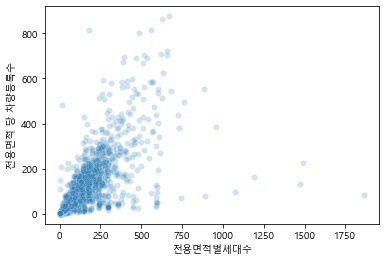

In [32]:
sns.scatterplot(data=train_df, x="전용면적별세대수", y="전용면적 당 차량등록수", alpha=0.2)

In [33]:
# 503, 1871, 1951, 1977, 2023

outlier_index = train_df[train_df["전용면적별세대수"] >= 1000].index
train_df = train_df.drop(index=outlier_index, axis=0)

In [34]:
outlier_index = train_df[(train_df["전용면적별세대수"] <= 30) & (train_df["전용면적 당 차량등록수"] >=400)].index
train_df = train_df.drop(index=outlier_index, axis=0)

In [35]:
# 301 아웃라이어 제거

train_df[(train_df["전용면적별세대수"] > 150) & (train_df["전용면적 당 차량등록수"] > 750)]

train_df = train_df.drop(index=301, axis=0)

<AxesSubplot:xlabel='전용면적별세대수', ylabel='Count'>

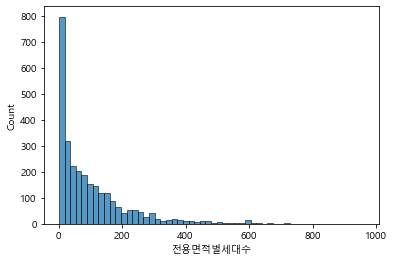

In [36]:
sns.histplot(train_df["전용면적별세대수"])

<AxesSubplot:xlabel='세대수 규모 당 총 전용면적', ylabel='전용면적 당 차량등록수'>

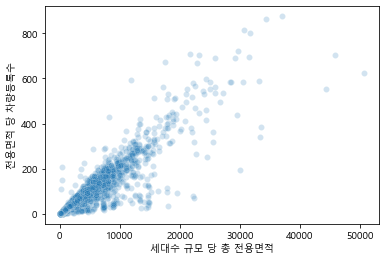

In [37]:
sns.scatterplot(data=train_df, x="세대수 규모 당 총 전용면적", y="전용면적 당 차량등록수", alpha=0.2)

In [38]:
# 1974, 2141, 2532

outlier_index = train_df[train_df["세대수 규모 당 총 전용면적"] > 40000].index

train_df = train_df.drop(index=outlier_index, axis=0)

<AxesSubplot:xlabel='세대수 규모 당 총 전용면적', ylabel='Count'>

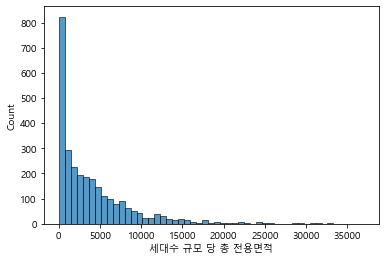

In [39]:
sns.histplot(train_df["세대수 규모 당 총 전용면적"])

<AxesSubplot:xlabel='임대보증금', ylabel='전용면적 당 차량등록수'>

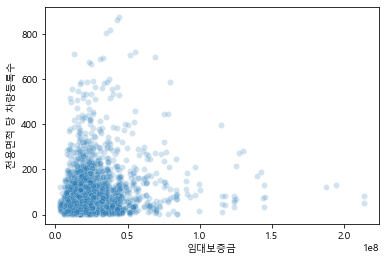

In [44]:
sns.scatterplot(data=train_df, x="임대보증금", y="전용면적 당 차량등록수", alpha=0.2)

In [45]:
# 임대보증금 아웃라이어 2111, 2812, 2813, 2814 제거

outlier_index = train_df[train_df["임대보증금"] >= 187694000].index
train_df = train_df.drop(index=outlier_index, axis=0)

<AxesSubplot:xlabel='세대수비율주차면수', ylabel='전용면적 당 차량등록수'>

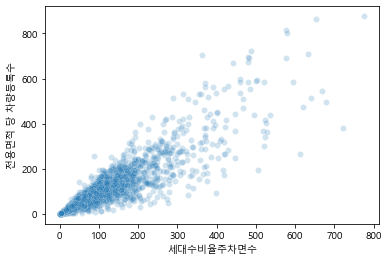

In [58]:
sns.scatterplot(data=train_df, x="세대수비율주차면수", y="전용면적 당 차량등록수", alpha=0.2)

In [59]:
# 세대수비율주차면수 아웃라이어 제거 314

outlier_index = train_df[(train_df["세대수비율주차면수"] >= 700) & (train_df["전용면적 당 차량등록수"] < 400)].index
train_df = train_df.drop(index=outlier_index, axis=0)

In [60]:
# correlation_df = train_df.corr().sort_values(by="전용면적 당 차량등록수", ascending=False)

# plt.figure(figsize=(20, 16))
# sns.heatmap(correlation_df, annot=True, fmt=".4f", cmap='YlGnBu')

In [61]:
# X_train & X_test 셋 선택

X_train_df_sel = train_df.drop(["단지코드", "상가", "등록차량수", "단지내주차면수", "단지별 총 전용면적", "실거주세대수", "지역", "공급유형", "전용면적", "자격유형", "임대료",
 "전용면적 당 차량등록수", "총세대수"], axis=1)

X_test_df_sel = test_df.drop(["단지코드", "상가", "단지내주차면수", "단지별 총 전용면적", "실거주세대수", "지역", "공급유형", "전용면적", "자격유형", "임대료",
 "총세대수"], axis=1)

y_train_df = train_df["전용면적 당 차량등록수"]

In [62]:
X_train_df_sel.columns

Index(['전용면적별세대수', '공가수', '임대보증금', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '세대수비율주차면수', '10대미만(여자)', '10대미만(남자)',
       '10대(여자)', '10대(남자)', '20대(여자)', '20대(남자)', '30대(여자)', '30대(남자)',
       '40대(여자)', '40대(남자)', '50대(여자)', '50대(남자)', '60대(여자)', '60대(남자)',
       '70대(여자)', '70대(남자)', '80대(여자)', '80대(남자)', '90대(여자)', '90대(남자)',
       '100대(여자)', '100대(남자)', '강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시',
       '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도',
       '충청북도', '아파트', '세대수 규모 당 총 전용면적'],
      dtype='object')

In [63]:
column_names = ['전용면적별세대수', '공가수', '임대보증금', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '세대수비율주차면수', '10대미만(여자)', '10대미만(남자)',
       '10대(여자)', '10대(남자)', '20대(여자)', '20대(남자)', '30대(여자)', '30대(남자)',
       '40대(여자)', '40대(남자)', '50대(여자)', '50대(남자)', '60대(여자)', '60대(남자)',
       '70대(여자)', '70대(남자)', '80대(여자)', '80대(남자)', '90대(여자)', '90대(남자)',
       '100대(여자)', '100대(남자)', '강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시',
       '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도',
       '충청북도', '아파트', '세대수 규모 당 총 전용면적']

X_test_df_sel = X_test_df_sel.reindex(columns=column_names)
X_test_df_sel.columns

Index(['전용면적별세대수', '공가수', '임대보증금', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '세대수비율주차면수', '10대미만(여자)', '10대미만(남자)',
       '10대(여자)', '10대(남자)', '20대(여자)', '20대(남자)', '30대(여자)', '30대(남자)',
       '40대(여자)', '40대(남자)', '50대(여자)', '50대(남자)', '60대(여자)', '60대(남자)',
       '70대(여자)', '70대(남자)', '80대(여자)', '80대(남자)', '90대(여자)', '90대(남자)',
       '100대(여자)', '100대(남자)', '강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시',
       '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도',
       '충청북도', '아파트', '세대수 규모 당 총 전용면적'],
      dtype='object')

In [64]:
X_train_df_sel

,전용면적별세대수,공가수,임대보증금,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,A,B,C,D,E,...,부산광역시,세종특별자치시,울산광역시,전라남도,전라북도,제주특별자치도,충청남도,충청북도,아파트,세대수 규모 당 총 전용면적
0,276,17.0,9216000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,8280.0
1,60,17.0,12672000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2100.0
2,20,17.0,12672000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,700.0
3,38,17.0,18433000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1710.0
4,19,17.0,18433000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,855.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864,30,7.0,39000000.0,0.0,2.0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1650.0
2865,156,7.0,49000000.0,0.0,2.0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,10920.0
2866,78,7.0,49000000.0,0.0,2.0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,5460.0
2867,160,7.0,61000000.0,0.0,2.0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,12800.0


In [65]:
X_train_df_log = X_train_df_sel.apply(lambda x: np.log1p(x))
X_test_df_log = X_test_df_sel.apply(lambda x: np.log1p(x))
y_train_df_log = y_train_df.apply(lambda x: np.log1p(x))

### CatBoost 모델 평가

In [67]:
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

cat_reg = CatBoostRegressor(random_seed=42)
X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25, random_state=42)

cat_reg.fit(X_train, y_train)
pred = cat_reg.predict(X_test)

mean_absolute_error(np.expm1(y_test), np.expm1(pred))

Learning rate set to 0.04469
0:	learn: 1.7833227	total: 141ms	remaining: 2m 21s
1:	learn: 1.7132356	total: 148ms	remaining: 1m 13s
2:	learn: 1.6480363	total: 154ms	remaining: 51.2s
3:	learn: 1.5827062	total: 159ms	remaining: 39.7s
4:	learn: 1.5205217	total: 163ms	remaining: 32.4s
5:	learn: 1.4602597	total: 166ms	remaining: 27.5s
6:	learn: 1.4039698	total: 169ms	remaining: 24s
7:	learn: 1.3511090	total: 170ms	remaining: 21.1s
8:	learn: 1.2993372	total: 172ms	remaining: 18.9s
9:	learn: 1.2511378	total: 173ms	remaining: 17.1s
10:	learn: 1.2050387	total: 175ms	remaining: 15.7s
11:	learn: 1.1599517	total: 176ms	remaining: 14.5s
12:	learn: 1.1164405	total: 178ms	remaining: 13.5s
13:	learn: 1.0771545	total: 179ms	remaining: 12.6s
14:	learn: 1.0373653	total: 180ms	remaining: 11.9s
15:	learn: 0.9985036	total: 182ms	remaining: 11.2s
16:	learn: 0.9630959	total: 183ms	remaining: 10.6s
17:	learn: 0.9285942	total: 185ms	remaining: 10.1s
18:	learn: 0.8980845	total: 186ms	remaining: 9.62s
19:	learn: 0

262:	learn: 0.1849813	total: 515ms	remaining: 1.44s
263:	learn: 0.1845801	total: 517ms	remaining: 1.44s
264:	learn: 0.1845376	total: 518ms	remaining: 1.44s
265:	learn: 0.1841821	total: 519ms	remaining: 1.43s
266:	learn: 0.1841404	total: 521ms	remaining: 1.43s
267:	learn: 0.1840809	total: 522ms	remaining: 1.43s
268:	learn: 0.1836302	total: 523ms	remaining: 1.42s
269:	learn: 0.1833810	total: 525ms	remaining: 1.42s
270:	learn: 0.1830741	total: 526ms	remaining: 1.42s
271:	learn: 0.1828665	total: 528ms	remaining: 1.41s
272:	learn: 0.1825562	total: 529ms	remaining: 1.41s
273:	learn: 0.1821990	total: 531ms	remaining: 1.41s
274:	learn: 0.1820077	total: 532ms	remaining: 1.4s
275:	learn: 0.1816860	total: 533ms	remaining: 1.4s
276:	learn: 0.1814361	total: 535ms	remaining: 1.4s
277:	learn: 0.1811452	total: 536ms	remaining: 1.39s
278:	learn: 0.1808626	total: 537ms	remaining: 1.39s
279:	learn: 0.1804736	total: 539ms	remaining: 1.39s
280:	learn: 0.1802834	total: 540ms	remaining: 1.38s
281:	learn: 0.1

506:	learn: 0.1430677	total: 862ms	remaining: 838ms
507:	learn: 0.1429855	total: 879ms	remaining: 851ms
508:	learn: 0.1426198	total: 882ms	remaining: 850ms
509:	learn: 0.1424209	total: 884ms	remaining: 850ms
510:	learn: 0.1421861	total: 887ms	remaining: 849ms
511:	learn: 0.1420420	total: 890ms	remaining: 848ms
512:	learn: 0.1419123	total: 892ms	remaining: 847ms
513:	learn: 0.1417692	total: 894ms	remaining: 846ms
514:	learn: 0.1417384	total: 896ms	remaining: 844ms
515:	learn: 0.1417028	total: 898ms	remaining: 843ms
516:	learn: 0.1415066	total: 900ms	remaining: 841ms
517:	learn: 0.1412977	total: 902ms	remaining: 839ms
518:	learn: 0.1411298	total: 903ms	remaining: 837ms
519:	learn: 0.1409863	total: 905ms	remaining: 835ms
520:	learn: 0.1409030	total: 906ms	remaining: 833ms
521:	learn: 0.1406529	total: 908ms	remaining: 831ms
522:	learn: 0.1405882	total: 909ms	remaining: 829ms
523:	learn: 0.1403840	total: 911ms	remaining: 827ms
524:	learn: 0.1401356	total: 912ms	remaining: 825ms
525:	learn: 

738:	learn: 0.1169694	total: 1.2s	remaining: 423ms
739:	learn: 0.1169327	total: 1.2s	remaining: 422ms
740:	learn: 0.1168613	total: 1.2s	remaining: 420ms
741:	learn: 0.1167979	total: 1.2s	remaining: 418ms
742:	learn: 0.1166651	total: 1.2s	remaining: 416ms
743:	learn: 0.1165396	total: 1.21s	remaining: 415ms
744:	learn: 0.1164809	total: 1.21s	remaining: 413ms
745:	learn: 0.1164683	total: 1.21s	remaining: 411ms
746:	learn: 0.1164448	total: 1.21s	remaining: 410ms
747:	learn: 0.1163575	total: 1.21s	remaining: 408ms
748:	learn: 0.1163410	total: 1.21s	remaining: 406ms
749:	learn: 0.1162341	total: 1.21s	remaining: 405ms
750:	learn: 0.1161163	total: 1.21s	remaining: 403ms
751:	learn: 0.1160320	total: 1.22s	remaining: 401ms
752:	learn: 0.1159833	total: 1.22s	remaining: 399ms
753:	learn: 0.1159137	total: 1.22s	remaining: 398ms
754:	learn: 0.1158490	total: 1.22s	remaining: 396ms
755:	learn: 0.1157503	total: 1.22s	remaining: 394ms
756:	learn: 0.1155342	total: 1.22s	remaining: 393ms
757:	learn: 0.115

994:	learn: 0.0952198	total: 1.54s	remaining: 7.74ms
995:	learn: 0.0951046	total: 1.54s	remaining: 6.19ms
996:	learn: 0.0950541	total: 1.54s	remaining: 4.64ms
997:	learn: 0.0950227	total: 1.54s	remaining: 3.09ms
998:	learn: 0.0949876	total: 1.54s	remaining: 1.55ms
999:	learn: 0.0949603	total: 1.55s	remaining: 0us


9.20313874587702

In [68]:
cat_reg = CatBoostRegressor(random_seed=42)

cat_reg.fit(X_train_df_log, y_train_df_log)
pred = cat_reg.predict(X_test_df_log)
pred = np.expm1(pred)

result = pd.DataFrame(data=pred, columns=["전용면적 당 차량등록수"], index=test_df.index)
result["단지코드"] = test_df.loc[test_df.index, "단지코드"]

pred_group = result.groupby("단지코드")["전용면적 당 차량등록수"].sum()
final_pred = pd.Series(pred_group)
final_pred = final_pred.reset_index(drop=False)

sub_df = sub.merge(final_pred, how="left")
sub_df = sub_df.drop_duplicates(["단지코드"], keep="first").reset_index()
sub_df = sub_df[["단지코드", "전용면적 당 차량등록수"]]
sub_df = sub_df.rename(columns={"단지코드":"code", "전용면적 당 차량등록수": "num"})
# sub_df.to_csv("ridge_with_이상치처리_다중공선성피처제거_0722.csv", index=False)

sub_df

Learning rate set to 0.04704
0:	learn: 1.7677683	total: 1.68ms	remaining: 1.68s
1:	learn: 1.6943980	total: 3.26ms	remaining: 1.63s
2:	learn: 1.6261231	total: 4.69ms	remaining: 1.56s
3:	learn: 1.5579698	total: 6.15ms	remaining: 1.53s
4:	learn: 1.4969199	total: 7.25ms	remaining: 1.44s
5:	learn: 1.4350836	total: 8.81ms	remaining: 1.46s
6:	learn: 1.3764565	total: 10.2ms	remaining: 1.45s
7:	learn: 1.3216776	total: 11.7ms	remaining: 1.45s
8:	learn: 1.2682337	total: 13.2ms	remaining: 1.45s
9:	learn: 1.2158833	total: 14.6ms	remaining: 1.44s
10:	learn: 1.1700141	total: 16ms	remaining: 1.44s
11:	learn: 1.1238904	total: 17.4ms	remaining: 1.43s
12:	learn: 1.0793263	total: 18.8ms	remaining: 1.43s
13:	learn: 1.0391168	total: 20.2ms	remaining: 1.42s
14:	learn: 0.9992440	total: 21.7ms	remaining: 1.43s
15:	learn: 0.9596211	total: 23.1ms	remaining: 1.42s
16:	learn: 0.9240064	total: 24.6ms	remaining: 1.42s
17:	learn: 0.8895403	total: 26ms	remaining: 1.42s
18:	learn: 0.8605455	total: 26.9ms	remaining: 1.3

186:	learn: 0.2034813	total: 269ms	remaining: 1.17s
187:	learn: 0.2028847	total: 270ms	remaining: 1.17s
188:	learn: 0.2027065	total: 272ms	remaining: 1.17s
189:	learn: 0.2022535	total: 273ms	remaining: 1.16s
190:	learn: 0.2016716	total: 275ms	remaining: 1.16s
191:	learn: 0.2014018	total: 276ms	remaining: 1.16s
192:	learn: 0.2011215	total: 278ms	remaining: 1.16s
193:	learn: 0.2005782	total: 279ms	remaining: 1.16s
194:	learn: 0.2002366	total: 280ms	remaining: 1.16s
195:	learn: 0.1999350	total: 282ms	remaining: 1.16s
196:	learn: 0.1995697	total: 283ms	remaining: 1.16s
197:	learn: 0.1992594	total: 285ms	remaining: 1.15s
198:	learn: 0.1990848	total: 286ms	remaining: 1.15s
199:	learn: 0.1985859	total: 288ms	remaining: 1.15s
200:	learn: 0.1984353	total: 289ms	remaining: 1.15s
201:	learn: 0.1978869	total: 291ms	remaining: 1.15s
202:	learn: 0.1977230	total: 293ms	remaining: 1.15s
203:	learn: 0.1972708	total: 294ms	remaining: 1.15s
204:	learn: 0.1970280	total: 296ms	remaining: 1.15s
205:	learn: 

355:	learn: 0.1635121	total: 509ms	remaining: 921ms
356:	learn: 0.1633240	total: 510ms	remaining: 919ms
357:	learn: 0.1629346	total: 512ms	remaining: 918ms
358:	learn: 0.1627350	total: 513ms	remaining: 916ms
359:	learn: 0.1624902	total: 515ms	remaining: 915ms
360:	learn: 0.1624127	total: 516ms	remaining: 914ms
361:	learn: 0.1622883	total: 518ms	remaining: 913ms
362:	learn: 0.1620506	total: 519ms	remaining: 911ms
363:	learn: 0.1619723	total: 521ms	remaining: 910ms
364:	learn: 0.1618329	total: 522ms	remaining: 908ms
365:	learn: 0.1616551	total: 523ms	remaining: 907ms
366:	learn: 0.1614758	total: 525ms	remaining: 906ms
367:	learn: 0.1613968	total: 526ms	remaining: 904ms
368:	learn: 0.1612062	total: 528ms	remaining: 902ms
369:	learn: 0.1610730	total: 529ms	remaining: 901ms
370:	learn: 0.1607744	total: 531ms	remaining: 899ms
371:	learn: 0.1606149	total: 532ms	remaining: 898ms
372:	learn: 0.1604476	total: 533ms	remaining: 897ms
373:	learn: 0.1604235	total: 535ms	remaining: 895ms
374:	learn: 

550:	learn: 0.1339855	total: 781ms	remaining: 637ms
551:	learn: 0.1339410	total: 783ms	remaining: 635ms
552:	learn: 0.1339001	total: 784ms	remaining: 634ms
553:	learn: 0.1338271	total: 785ms	remaining: 632ms
554:	learn: 0.1336939	total: 787ms	remaining: 631ms
555:	learn: 0.1336048	total: 788ms	remaining: 630ms
556:	learn: 0.1335119	total: 790ms	remaining: 628ms
557:	learn: 0.1332982	total: 791ms	remaining: 627ms
558:	learn: 0.1330090	total: 793ms	remaining: 625ms
559:	learn: 0.1328888	total: 794ms	remaining: 624ms
560:	learn: 0.1327673	total: 796ms	remaining: 623ms
561:	learn: 0.1326784	total: 797ms	remaining: 621ms
562:	learn: 0.1325286	total: 798ms	remaining: 620ms
563:	learn: 0.1324580	total: 800ms	remaining: 618ms
564:	learn: 0.1323668	total: 801ms	remaining: 617ms
565:	learn: 0.1322649	total: 802ms	remaining: 615ms
566:	learn: 0.1321159	total: 804ms	remaining: 614ms
567:	learn: 0.1320337	total: 805ms	remaining: 612ms
568:	learn: 0.1316668	total: 807ms	remaining: 611ms
569:	learn: 

723:	learn: 0.1161254	total: 1.02s	remaining: 390ms
724:	learn: 0.1159471	total: 1.02s	remaining: 389ms
725:	learn: 0.1159367	total: 1.03s	remaining: 388ms
726:	learn: 0.1159040	total: 1.03s	remaining: 386ms
727:	learn: 0.1158336	total: 1.03s	remaining: 385ms
728:	learn: 0.1156176	total: 1.03s	remaining: 383ms
729:	learn: 0.1155872	total: 1.03s	remaining: 382ms
730:	learn: 0.1154332	total: 1.03s	remaining: 381ms
731:	learn: 0.1153787	total: 1.03s	remaining: 379ms
732:	learn: 0.1152659	total: 1.04s	remaining: 378ms
733:	learn: 0.1151535	total: 1.04s	remaining: 376ms
734:	learn: 0.1150859	total: 1.04s	remaining: 375ms
735:	learn: 0.1150133	total: 1.04s	remaining: 374ms
736:	learn: 0.1149094	total: 1.04s	remaining: 372ms
737:	learn: 0.1147665	total: 1.04s	remaining: 371ms
738:	learn: 0.1145727	total: 1.05s	remaining: 370ms
739:	learn: 0.1145288	total: 1.05s	remaining: 368ms
740:	learn: 0.1143511	total: 1.05s	remaining: 367ms
741:	learn: 0.1143019	total: 1.05s	remaining: 365ms
742:	learn: 

903:	learn: 0.1018694	total: 1.29s	remaining: 137ms
904:	learn: 0.1018106	total: 1.29s	remaining: 136ms
905:	learn: 0.1017247	total: 1.3s	remaining: 134ms
906:	learn: 0.1015984	total: 1.3s	remaining: 133ms
907:	learn: 0.1014830	total: 1.3s	remaining: 132ms
908:	learn: 0.1014433	total: 1.3s	remaining: 130ms
909:	learn: 0.1013585	total: 1.3s	remaining: 129ms
910:	learn: 0.1012894	total: 1.3s	remaining: 127ms
911:	learn: 0.1012424	total: 1.3s	remaining: 126ms
912:	learn: 0.1011996	total: 1.31s	remaining: 124ms
913:	learn: 0.1011634	total: 1.31s	remaining: 123ms
914:	learn: 0.1011186	total: 1.31s	remaining: 122ms
915:	learn: 0.1010428	total: 1.31s	remaining: 120ms
916:	learn: 0.1010194	total: 1.31s	remaining: 119ms
917:	learn: 0.1009671	total: 1.31s	remaining: 117ms
918:	learn: 0.1008977	total: 1.31s	remaining: 116ms
919:	learn: 0.1007961	total: 1.32s	remaining: 114ms
920:	learn: 0.1006831	total: 1.32s	remaining: 113ms
921:	learn: 0.1006295	total: 1.32s	remaining: 112ms
922:	learn: 0.10056

,code,num
0,C1072,739.981744
1,C1128,1424.157918
2,C1456,487.811929
3,C1840,442.836811
4,C1332,1187.143662
...,...,...
145,C2456,277.301850
146,C1266,394.835115
147,C2152,28.502060
148,C1267,338.668978


### Linear Regression 모델 평가

In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

In [70]:
params = {"alpha": [0.01, 0.1, 0.3, 0.5, 1, 3, 5, 10, 20, 25, 30, 35, 40, 45, 50]}

elastic_params = {"alpha": [0.01, 0.1, 0.3, 0.5, 1, 3, 5, 10, 20],
                 "l1_ratio": [0.1, 0.3, 0.5, 0.7, 1]}


ridge = Ridge()
lasso = Lasso()
elastic = ElasticNet()

grid_ridge = GridSearchCV(ridge, param_grid=params, cv=5, scoring="neg_mean_absolute_error")
grid_lasso = GridSearchCV(lasso, param_grid=params, cv=5, scoring="neg_mean_absolute_error")
grid_elastic = GridSearchCV(elastic, param_grid=elastic_params, cv=5, scoring="neg_mean_absolute_error")

grid_ridge.fit(X_train_df_log, y_train_df_log)
grid_lasso.fit(X_train_df_log, y_train_df_log)
grid_elastic.fit(X_train_df_log, y_train_df_log)

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.01, 0.1, 0.3, 0.5, 1, 3, 5, 10, 20],
                         'l1_ratio': [0.1, 0.3, 0.5, 0.7, 1]},
             scoring='neg_mean_absolute_error')

In [71]:
grid_ridge.best_params_

{'alpha': 50}

In [ ]:
grid_lasso.best_params_

### 랜덤포레스트 모델 및 선형회귀 모델 평가

In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

rf_reg = RandomForestRegressor(n_jobs=-1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25, random_state=42)

rf_reg.fit(X_train, y_train)
pred = rf_reg.predict(X_test)

mean_absolute_error(np.expm1(y_test), np.expm1(pred))

In [73]:
lasso_model = Lasso(alpha=0.01)
X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25, random_state=42)

lasso_model.fit(X_train, y_train)
pred = lasso_model.predict(X_test)


mean_absolute_error(np.expm1(y_test), np.expm1(pred))

In [74]:
ridge_model = Ridge(alpha=50)
X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25, random_state=42)

ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)


mean_absolute_error(np.expm1(y_test), np.expm1(ridge_pred))

15.02296856680242

In [75]:
ridge_model.coef_

array([ 2.92196633e-02, -4.87854091e-02,  2.38860372e-01, -6.75493531e-02,
        2.43510560e-03,  2.11609448e-01,  7.29241400e-02, -2.82830483e-01,
        1.97041447e-01, -1.01709699e-01, -2.52292167e-02, -3.59875642e-02,
        2.02089438e-01,  7.59619263e-02, -1.03137525e-01, -1.06040853e-01,
        1.46857041e-02, -2.97074261e-02, -8.61170615e-02, -3.55227579e-03,
        5.82044176e-01,  4.88419786e-03,  6.26759183e-03,  9.00785104e-03,
        9.34608542e-03,  4.90628884e-03,  3.75013358e-03,  4.59472821e-03,
        2.73840277e-03,  7.42457544e-03,  4.36454497e-03,  1.45244702e-03,
        1.78686528e-03, -1.39987171e-02, -8.07200509e-03, -1.47817659e-02,
       -1.02976867e-02, -6.42702436e-03, -4.66116575e-03, -1.27582011e-03,
       -6.39187031e-04, -3.96693573e-05, -2.72363765e-06,  2.74898407e-02,
       -6.26309322e-02, -1.42361214e-01,  1.65430111e-01,  1.18649687e-01,
        1.15513570e-01, -1.30692584e-01, -1.01938162e-01,  5.66321884e-02,
       -3.31141914e-02,  

In [76]:
X_train_df_log.columns

Index(['전용면적별세대수', '공가수', '임대보증금', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '세대수비율주차면수', '10대미만(여자)', '10대미만(남자)',
       '10대(여자)', '10대(남자)', '20대(여자)', '20대(남자)', '30대(여자)', '30대(남자)',
       '40대(여자)', '40대(남자)', '50대(여자)', '50대(남자)', '60대(여자)', '60대(남자)',
       '70대(여자)', '70대(남자)', '80대(여자)', '80대(남자)', '90대(여자)', '90대(남자)',
       '100대(여자)', '100대(남자)', '강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시',
       '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도',
       '충청북도', '아파트', '세대수 규모 당 총 전용면적'],
      dtype='object')

In [77]:
# ridge_model = Ridge(alpha=20)

# ridge_model.fit(X_train_df_log, y_train_df_log)
# pred = ridge_model.predict(X_test_df_log)
# pred = np.expm1(pred)

# result = pd.DataFrame(data=pred, columns=["전용면적 당 차량등록수"], index=test_df.index)
# result["단지코드"] = test_df.loc[test_df.index, "단지코드"]

# pred_group = result.groupby("단지코드")["전용면적 당 차량등록수"].sum()
# final_pred = pd.Series(pred_group)
# final_pred = final_pred.reset_index(drop=False)

# sub = sub.rename(columns={"code":"단지코드"})
# sub_df1 = sub.merge(final_pred, how="left")
# sub_df1 = sub_df1.drop_duplicates(["단지코드"], keep="first").reset_index()
# sub_df1 = sub_df1[["단지코드", "전용면적 당 차량등록수"]]
# sub_df1 = sub_df1.rename(columns={"단지코드":"code", "전용면적 당 차량등록수": "num"})
# # sub_df.to_csv("ridge_with_이상치처리_다중공선성피처제거_인구데이터추가_0723.csv", index=False)

# sub_df1

In [78]:
# feature_importance = pd.Series(data=ridge_model.coef_, index=X_train_df_log.columns)
# feature_importance = feature_importance.sort_values(ascending=False)

# plt.figure(figsize=(20, 12))
# sns.barplot(x=feature_importance, y=feature_importance.index)
# plt.show()

#### 인구 데이터를 +-0.1 상관관계 기준으로 모두 넣었는데 95.7105 가 나옴

#### 추가로 해봐야 할 부분 
* 인구 데이터의 다중공선성이 있는 피처들을 선별해서 제거한다
* 정규분포를 띄는 인구 피처들을 선별해서 추가해본다
* 인구 피처와 기존 피처들을 결합해보기

In [79]:
from lightgbm import LGBMRegressor

# params = {
#     "max_depth": [-1, 5, 10, 20, 30],
#     "colsample_bytree": [1, 0.7, 0.8, 0.9],
#     "boosting_type": ["rf", "gbdt", "dart", "goss"],
#     "metrics": ["l1"],
#     "learning_rate": [0.01, 0.05, 0.07, 0.1, 0.2],
#     "num_iterations": [100, 200, 300, 500, 1000]
# }

# lgbm_reg = LGBMRegressor(random_state=42, n_jobs=-1)
# grid_model = GridSearchCV(lgbm_reg, param_grid=params, cv=5, scoring="neg_mean_absolute_error")
# grid_model.fit(X_train_df_log, y_train_df_log)

In [80]:
# grid_model.best_params_

### lgbm 파라미터 튜닝 -> 그리드 서치로 찾아낸 최적 파라미터 조합

'boosting_type': 'dart',
'colsample_bytree': 1,
'learning_rate': 0.2,
'max_depth': 10,
'metrics': 'l1',
'num_iterations': 1000

In [81]:
# grid_model.best_score_

In [82]:
# lgbm_best = grid_model.best_estimator_
# lgbm_pred = lgbm_best.predict(X_test)

# mean_absolute_error(np.expm1(y_test), np.expm1(lgbm_pred))

In [83]:
# # lgbm 최적 파라미터 찾은 것 적용해서 예측 -> 104점대 나옴
# # lgbm 1.0 -> 11.4743

# pred = lgbm_best.predict(X_test_df_log)
# pred = np.expm1(pred)

# result = pd.DataFrame(data=pred, columns=["전용면적 당 차량등록수"], index=test_df.index)
# result["단지코드"] = test_df.loc[test_df.index, "단지코드"]

# pred_group = result.groupby("단지코드")["전용면적 당 차량등록수"].sum()
# final_pred = pd.Series(pred_group)
# final_pred = final_pred.reset_index(drop=False)

# sub = sub.rename(columns={"code":"단지코드"})
# sub_df3 = sub.merge(final_pred, how="left")
# sub_df3 = sub_df3.drop_duplicates(["단지코드"], keep="first").reset_index()
# sub_df3 = sub_df3[["단지코드", "전용면적 당 차량등록수"]]
# sub_df3 = sub_df3.rename(columns={"단지코드":"code", "전용면적 당 차량등록수": "num"})
# sub_df3.to_csv("lgbm_그리드서치_하이퍼파라미터셋팅_인구데이터추가_0723.csv", index=False)

# sub_df3

In [84]:
# lgbm_best.feature_importances_

In [86]:
from lightgbm import LGBMRegressor

# lgbm_reg = LGBMRegressor(random_state=42, n_jobs=-1, boosting_type='dart', colsample_bytree=1, learning_rate=0.2, max_depth=10, metrics='l1', num_iterations=1000)
# lgbm_reg.fit(X_train, y_train)
# lgbm_pred = lgbm_reg.predict(X_test)

# final_pred = (ridge_pred * 0.5) + (lgbm_pred * 0.5)
# mean_absolute_error(np.expm1(y_test), np.expm1(final_pred))

In [87]:
# 릿지 & LGBM 0.5 조합 -> 12.3456 Score : 93.5424

# ridge_model = Ridge(alpha=20)
# ridge_model.fit(X_train_df_log, y_train_df_log)
# ridge_pred = ridge_model.predict(X_test_df_log)
# ridge_pred = np.expm1(ridge_pred)

# lgbm_reg = LGBMRegressor(random_state=42, n_jobs=-1, boosting_type='dart', colsample_bytree=1,
#  early_stopping_round=50, learning_rate=0.2, max_depth=10, metrics='l1', num_iterations=1000)
# lgbm_reg.fit(X_train_df_log, y_train_df_log)
# lgbm_pred = lgbm_best.predict(X_test_df_log)
# lgbm_pred = np.expm1(lgbm_pred)

# final_pred = (ridge_pred * 0.5) + (lgbm_pred * 0.5)

# result = pd.DataFrame(data=final_pred, columns=["전용면적 당 차량등록수"], index=test_df.index)
# result["단지코드"] = test_df.loc[test_df.index, "단지코드"]

# pred_group = result.groupby("단지코드")["전용면적 당 차량등록수"].sum()
# final_pred = pd.Series(pred_group)
# final_pred = final_pred.reset_index(drop=False)

# sub = sub.rename(columns={"code":"단지코드"})
# sub_df2 = sub.merge(final_pred, how="left")
# sub_df2 = sub_df2.drop_duplicates(["단지코드"], keep="first").reset_index()
# sub_df2 = sub_df2[["단지코드", "전용면적 당 차량등록수"]]
# sub_df2 = sub_df2.rename(columns={"단지코드":"code", "전용면적 당 차량등록수": "num"})
# sub_df2.to_csv("ridge(0.5)_lgbm(0.5)_lgbm파라미터최적화_인구데이터적용_0724.csv", index=False)

# sub_df2

In [85]:
# 릿지 & CatBoost 0.5 조합 -> 11.3355

ridge_model = Ridge(alpha=20)
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)

cat_reg = CatBoostRegressor(random_seed=42)
cat_reg.fit(X_train, y_train)
cat_pred = cat_reg.predict(X_test)

final_pred = (ridge_pred * 0.5) + (cat_pred * 0.5)
mean_absolute_error(np.expm1(y_test), np.expm1(final_pred))

Learning rate set to 0.04469
0:	learn: 1.7833227	total: 11.1ms	remaining: 11.1s
1:	learn: 1.7132356	total: 12.6ms	remaining: 6.28s
2:	learn: 1.6480363	total: 14.1ms	remaining: 4.68s
3:	learn: 1.5827062	total: 15.5ms	remaining: 3.87s
4:	learn: 1.5205217	total: 16.6ms	remaining: 3.3s
5:	learn: 1.4602597	total: 18ms	remaining: 2.98s
6:	learn: 1.4039698	total: 19.5ms	remaining: 2.76s
7:	learn: 1.3511090	total: 21ms	remaining: 2.61s
8:	learn: 1.2993372	total: 22.6ms	remaining: 2.49s
9:	learn: 1.2511378	total: 24.2ms	remaining: 2.4s
10:	learn: 1.2050387	total: 25.7ms	remaining: 2.31s
11:	learn: 1.1599517	total: 27.2ms	remaining: 2.24s
12:	learn: 1.1164405	total: 28.6ms	remaining: 2.17s
13:	learn: 1.0771545	total: 30.1ms	remaining: 2.12s
14:	learn: 1.0373653	total: 31.6ms	remaining: 2.08s
15:	learn: 0.9985036	total: 33ms	remaining: 2.03s
16:	learn: 0.9630959	total: 34.5ms	remaining: 2s
17:	learn: 0.9285942	total: 36.1ms	remaining: 1.97s
18:	learn: 0.8980845	total: 37.6ms	remaining: 1.94s
19:	

227:	learn: 0.1937775	total: 329ms	remaining: 1.11s
228:	learn: 0.1935872	total: 330ms	remaining: 1.11s
229:	learn: 0.1933322	total: 331ms	remaining: 1.11s
230:	learn: 0.1931270	total: 333ms	remaining: 1.11s
231:	learn: 0.1929577	total: 334ms	remaining: 1.1s
232:	learn: 0.1926282	total: 335ms	remaining: 1.1s
233:	learn: 0.1925521	total: 337ms	remaining: 1.1s
234:	learn: 0.1923748	total: 338ms	remaining: 1.1s
235:	learn: 0.1919347	total: 339ms	remaining: 1.1s
236:	learn: 0.1916233	total: 341ms	remaining: 1.1s
237:	learn: 0.1912142	total: 342ms	remaining: 1.09s
238:	learn: 0.1909410	total: 344ms	remaining: 1.09s
239:	learn: 0.1904585	total: 345ms	remaining: 1.09s
240:	learn: 0.1902093	total: 346ms	remaining: 1.09s
241:	learn: 0.1899633	total: 348ms	remaining: 1.09s
242:	learn: 0.1896844	total: 349ms	remaining: 1.09s
243:	learn: 0.1895609	total: 351ms	remaining: 1.09s
244:	learn: 0.1892727	total: 352ms	remaining: 1.08s
245:	learn: 0.1890844	total: 353ms	remaining: 1.08s
246:	learn: 0.1889

483:	learn: 0.1470993	total: 670ms	remaining: 714ms
484:	learn: 0.1470182	total: 671ms	remaining: 713ms
485:	learn: 0.1469701	total: 672ms	remaining: 711ms
486:	learn: 0.1466646	total: 674ms	remaining: 710ms
487:	learn: 0.1464000	total: 675ms	remaining: 708ms
488:	learn: 0.1461942	total: 677ms	remaining: 707ms
489:	learn: 0.1459148	total: 678ms	remaining: 706ms
490:	learn: 0.1456607	total: 680ms	remaining: 704ms
491:	learn: 0.1454998	total: 681ms	remaining: 703ms
492:	learn: 0.1451922	total: 683ms	remaining: 702ms
493:	learn: 0.1451727	total: 684ms	remaining: 700ms
494:	learn: 0.1450776	total: 685ms	remaining: 699ms
495:	learn: 0.1449355	total: 686ms	remaining: 698ms
496:	learn: 0.1448342	total: 688ms	remaining: 696ms
497:	learn: 0.1445710	total: 689ms	remaining: 695ms
498:	learn: 0.1443606	total: 690ms	remaining: 693ms
499:	learn: 0.1442468	total: 692ms	remaining: 692ms
500:	learn: 0.1439406	total: 693ms	remaining: 690ms
501:	learn: 0.1438617	total: 694ms	remaining: 689ms
502:	learn: 

735:	learn: 0.1171237	total: 1.01s	remaining: 362ms
736:	learn: 0.1170963	total: 1.01s	remaining: 361ms
737:	learn: 0.1170321	total: 1.01s	remaining: 360ms
738:	learn: 0.1169694	total: 1.01s	remaining: 358ms
739:	learn: 0.1169327	total: 1.01s	remaining: 357ms
740:	learn: 0.1168613	total: 1.02s	remaining: 355ms
741:	learn: 0.1167979	total: 1.02s	remaining: 354ms
742:	learn: 0.1166651	total: 1.02s	remaining: 353ms
743:	learn: 0.1165396	total: 1.02s	remaining: 351ms
744:	learn: 0.1164809	total: 1.02s	remaining: 350ms
745:	learn: 0.1164683	total: 1.02s	remaining: 349ms
746:	learn: 0.1164448	total: 1.02s	remaining: 347ms
747:	learn: 0.1163575	total: 1.03s	remaining: 346ms
748:	learn: 0.1163410	total: 1.03s	remaining: 345ms
749:	learn: 0.1162341	total: 1.03s	remaining: 343ms
750:	learn: 0.1161163	total: 1.03s	remaining: 342ms
751:	learn: 0.1160320	total: 1.03s	remaining: 340ms
752:	learn: 0.1159833	total: 1.03s	remaining: 339ms
753:	learn: 0.1159137	total: 1.03s	remaining: 338ms
754:	learn: 

982:	learn: 0.0960000	total: 1.35s	remaining: 23.3ms
983:	learn: 0.0959941	total: 1.35s	remaining: 22ms
984:	learn: 0.0959624	total: 1.35s	remaining: 20.6ms
985:	learn: 0.0959198	total: 1.35s	remaining: 19.2ms
986:	learn: 0.0958638	total: 1.35s	remaining: 17.8ms
987:	learn: 0.0957957	total: 1.36s	remaining: 16.5ms
988:	learn: 0.0957054	total: 1.36s	remaining: 15.1ms
989:	learn: 0.0955625	total: 1.36s	remaining: 13.7ms
990:	learn: 0.0954735	total: 1.36s	remaining: 12.4ms
991:	learn: 0.0954346	total: 1.36s	remaining: 11ms
992:	learn: 0.0952984	total: 1.36s	remaining: 9.61ms
993:	learn: 0.0952478	total: 1.36s	remaining: 8.24ms
994:	learn: 0.0952198	total: 1.37s	remaining: 6.86ms
995:	learn: 0.0951046	total: 1.37s	remaining: 5.49ms
996:	learn: 0.0950541	total: 1.37s	remaining: 4.12ms
997:	learn: 0.0950227	total: 1.37s	remaining: 2.75ms
998:	learn: 0.0949876	total: 1.37s	remaining: 1.37ms
999:	learn: 0.0949603	total: 1.37s	remaining: 0us


11.335534849438375

In [89]:
# ridge_model = Ridge(alpha=20)
# ridge_model.fit(X_train_df_log, y_train_df_log)
# ridge_pred = ridge_model.predict(X_test_df_log)
# ridge_pred = np.expm1(ridge_pred)

# cat_reg = CatBoostRegressor(random_seed=42)
# cat_reg.fit(X_train_df_log, y_train_df_log)
# cat_pred = cat_reg.predict(X_test_df_log)
# cat_pred = np.expm1(cat_pred)

# final_pred = (ridge_pred * 0.5) + (cat_pred * 0.5)

# result = pd.DataFrame(data=final_pred, columns=["전용면적 당 차량등록수"], index=test_df.index)
# result["단지코드"] = test_df.loc[test_df.index, "단지코드"]

# pred_group = result.groupby("단지코드")["전용면적 당 차량등록수"].sum()
# final_pred = pd.Series(pred_group)
# final_pred = final_pred.reset_index(drop=False)

# sub = sub.rename(columns={"code":"단지코드"})
# sub_df2 = sub.merge(final_pred, how="left")
# sub_df2 = sub_df2.drop_duplicates(["단지코드"], keep="first").reset_index()
# sub_df2 = sub_df2[["단지코드", "전용면적 당 차량등록수"]]
# sub_df2 = sub_df2.rename(columns={"단지코드":"code", "전용면적 당 차량등록수": "num"})
# sub_df2.to_csv("ridge(0.5)_catboost(0.5)_catboost기본모델_인구데이터적용_0725.csv", index=False)

# sub_df2

Learning rate set to 0.04704
0:	learn: 1.7677683	total: 1.4ms	remaining: 1.4s
1:	learn: 1.6943980	total: 3.09ms	remaining: 1.54s
2:	learn: 1.6261231	total: 4.76ms	remaining: 1.58s
3:	learn: 1.5579698	total: 6.39ms	remaining: 1.59s
4:	learn: 1.4969199	total: 7.62ms	remaining: 1.51s
5:	learn: 1.4350836	total: 9.19ms	remaining: 1.52s
6:	learn: 1.3764565	total: 10.7ms	remaining: 1.52s
7:	learn: 1.3216776	total: 12.3ms	remaining: 1.53s
8:	learn: 1.2682337	total: 13.9ms	remaining: 1.53s
9:	learn: 1.2158833	total: 15.4ms	remaining: 1.52s
10:	learn: 1.1700141	total: 17ms	remaining: 1.52s
11:	learn: 1.1238904	total: 18.5ms	remaining: 1.52s
12:	learn: 1.0793263	total: 20.1ms	remaining: 1.52s
13:	learn: 1.0391168	total: 21.6ms	remaining: 1.52s
14:	learn: 0.9992440	total: 23.2ms	remaining: 1.52s
15:	learn: 0.9596211	total: 24.7ms	remaining: 1.52s
16:	learn: 0.9240064	total: 26.3ms	remaining: 1.52s
17:	learn: 0.8895403	total: 27.9ms	remaining: 1.52s
18:	learn: 0.8605455	total: 28.9ms	remaining: 1.4

219:	learn: 0.1920072	total: 328ms	remaining: 1.16s
220:	learn: 0.1914420	total: 330ms	remaining: 1.16s
221:	learn: 0.1910610	total: 331ms	remaining: 1.16s
222:	learn: 0.1908693	total: 333ms	remaining: 1.16s
223:	learn: 0.1905338	total: 334ms	remaining: 1.16s
224:	learn: 0.1902883	total: 336ms	remaining: 1.16s
225:	learn: 0.1899231	total: 337ms	remaining: 1.15s
226:	learn: 0.1895179	total: 339ms	remaining: 1.15s
227:	learn: 0.1891894	total: 340ms	remaining: 1.15s
228:	learn: 0.1887789	total: 342ms	remaining: 1.15s
229:	learn: 0.1885274	total: 349ms	remaining: 1.17s
230:	learn: 0.1882106	total: 354ms	remaining: 1.18s
231:	learn: 0.1880041	total: 358ms	remaining: 1.18s
232:	learn: 0.1877198	total: 361ms	remaining: 1.19s
233:	learn: 0.1873190	total: 364ms	remaining: 1.19s
234:	learn: 0.1870217	total: 366ms	remaining: 1.19s
235:	learn: 0.1867371	total: 369ms	remaining: 1.19s
236:	learn: 0.1864996	total: 371ms	remaining: 1.2s
237:	learn: 0.1862967	total: 374ms	remaining: 1.2s
238:	learn: 0.

438:	learn: 0.1499026	total: 669ms	remaining: 855ms
439:	learn: 0.1498166	total: 671ms	remaining: 853ms
440:	learn: 0.1496558	total: 672ms	remaining: 852ms
441:	learn: 0.1494999	total: 674ms	remaining: 850ms
442:	learn: 0.1493439	total: 675ms	remaining: 849ms
443:	learn: 0.1492452	total: 677ms	remaining: 847ms
444:	learn: 0.1491162	total: 678ms	remaining: 846ms
445:	learn: 0.1488474	total: 680ms	remaining: 844ms
446:	learn: 0.1487599	total: 681ms	remaining: 843ms
447:	learn: 0.1486238	total: 683ms	remaining: 841ms
448:	learn: 0.1485714	total: 684ms	remaining: 839ms
449:	learn: 0.1484307	total: 685ms	remaining: 838ms
450:	learn: 0.1482855	total: 687ms	remaining: 836ms
451:	learn: 0.1482030	total: 688ms	remaining: 835ms
452:	learn: 0.1480881	total: 690ms	remaining: 833ms
453:	learn: 0.1479701	total: 691ms	remaining: 831ms
454:	learn: 0.1478765	total: 693ms	remaining: 830ms
455:	learn: 0.1476871	total: 694ms	remaining: 828ms
456:	learn: 0.1474823	total: 696ms	remaining: 827ms
457:	learn: 

673:	learn: 0.1206725	total: 1.01s	remaining: 488ms
674:	learn: 0.1206418	total: 1.01s	remaining: 487ms
675:	learn: 0.1205581	total: 1.01s	remaining: 485ms
676:	learn: 0.1205233	total: 1.01s	remaining: 484ms
677:	learn: 0.1204542	total: 1.01s	remaining: 482ms
678:	learn: 0.1204046	total: 1.02s	remaining: 481ms
679:	learn: 0.1203681	total: 1.02s	remaining: 479ms
680:	learn: 0.1202275	total: 1.02s	remaining: 478ms
681:	learn: 0.1201227	total: 1.02s	remaining: 476ms
682:	learn: 0.1200256	total: 1.02s	remaining: 475ms
683:	learn: 0.1199151	total: 1.02s	remaining: 473ms
684:	learn: 0.1198772	total: 1.02s	remaining: 472ms
685:	learn: 0.1198058	total: 1.03s	remaining: 470ms
686:	learn: 0.1196883	total: 1.03s	remaining: 469ms
687:	learn: 0.1196280	total: 1.03s	remaining: 467ms
688:	learn: 0.1195486	total: 1.03s	remaining: 465ms
689:	learn: 0.1194791	total: 1.03s	remaining: 464ms
690:	learn: 0.1194267	total: 1.03s	remaining: 462ms
691:	learn: 0.1193422	total: 1.03s	remaining: 461ms
692:	learn: 

911:	learn: 0.1012424	total: 1.35s	remaining: 130ms
912:	learn: 0.1011996	total: 1.35s	remaining: 129ms
913:	learn: 0.1011634	total: 1.35s	remaining: 127ms
914:	learn: 0.1011186	total: 1.36s	remaining: 126ms
915:	learn: 0.1010428	total: 1.36s	remaining: 125ms
916:	learn: 0.1010194	total: 1.36s	remaining: 123ms
917:	learn: 0.1009671	total: 1.36s	remaining: 122ms
918:	learn: 0.1008977	total: 1.36s	remaining: 120ms
919:	learn: 0.1007961	total: 1.36s	remaining: 119ms
920:	learn: 0.1006831	total: 1.36s	remaining: 117ms
921:	learn: 0.1006295	total: 1.37s	remaining: 116ms
922:	learn: 0.1005641	total: 1.37s	remaining: 114ms
923:	learn: 0.1005008	total: 1.37s	remaining: 113ms
924:	learn: 0.1002257	total: 1.37s	remaining: 111ms
925:	learn: 0.1001518	total: 1.37s	remaining: 110ms
926:	learn: 0.1000916	total: 1.37s	remaining: 108ms
927:	learn: 0.1000537	total: 1.37s	remaining: 107ms
928:	learn: 0.0999833	total: 1.38s	remaining: 105ms
929:	learn: 0.0999317	total: 1.38s	remaining: 104ms
930:	learn: 

,code,num
0,C1072,722.363467
1,C1128,1312.011872
2,C1456,515.710738
3,C1840,468.445213
4,C1332,1165.004303
...,...,...
145,C2456,252.351141
146,C1266,408.150915
147,C2152,30.808400
148,C1267,329.002981
